### Section 1: Overview and descriptive statistics

In [5]:
library(tidyverse)
library(data.table)
library(patchwork)
library(ggcorrplot)
library(ggpubr)
library(vroom)

setwd("~/work/mpra-v2")

`%notin%` = Negate(`%in%`)

In [6]:
mergedOligoSums = fread("data/1KG_bartenderOligoSums_novaSeq.txt")

In [7]:
mergedOligoCPM = mergedOligoSums
mergedOligoCPM[,10:21] = sweep(mergedOligoCPM[,10:21],
                                2,
                                colSums(mergedOligoCPM[,10:21])/1000000,
                                `/`)

dna1vdna2 = ggplot(mergedOligoCPM) + 
                geom_point(aes(x = plasmid1_ref, y = plasmid2_ref), alpha = 0.1, size = 3) +
                xlab("Plasmid Replicate 1 (Reference Allele)") + ylab("Plasmid Replicate 2 (Reference Allele)")
dna1vrna1 = ggplot(mergedOligoCPM) + 
                geom_point(aes(x = plasmid1_ref, y = cDNA1_ref), alpha = 0.1, size = 3) +
                xlab("Plasmid Replicate 1 (Reference Allele)") + ylab("cDNA Replicate 1(Reference Allele)")
dnaRefAlt = ggplot(mergedOligoCPM) + 
                geom_point(aes(x = plasmid1_ref, y = plasmid1_alt), alpha = 0.1, size = 3) +
                xlab("Plasmid Replicate 1 (Reference Allele)") + ylab("Plasmid Replicate 1 (Alternative Allele)")
rnaRefAlt = ggplot(mergedOligoCPM) + 
                geom_point(aes(x = cDNA1_ref, y = cDNA1_alt), alpha = 0.1, size = 3) +
                xlab("cDNA Replicate 1 (Reference Allele)") + ylab("cDNA Replicate 1 (Alternative Allele)")

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 93 rows containing missing values (geom_point).”
Warning message:
“Removed 138 rows containing missing values (geom_point).”


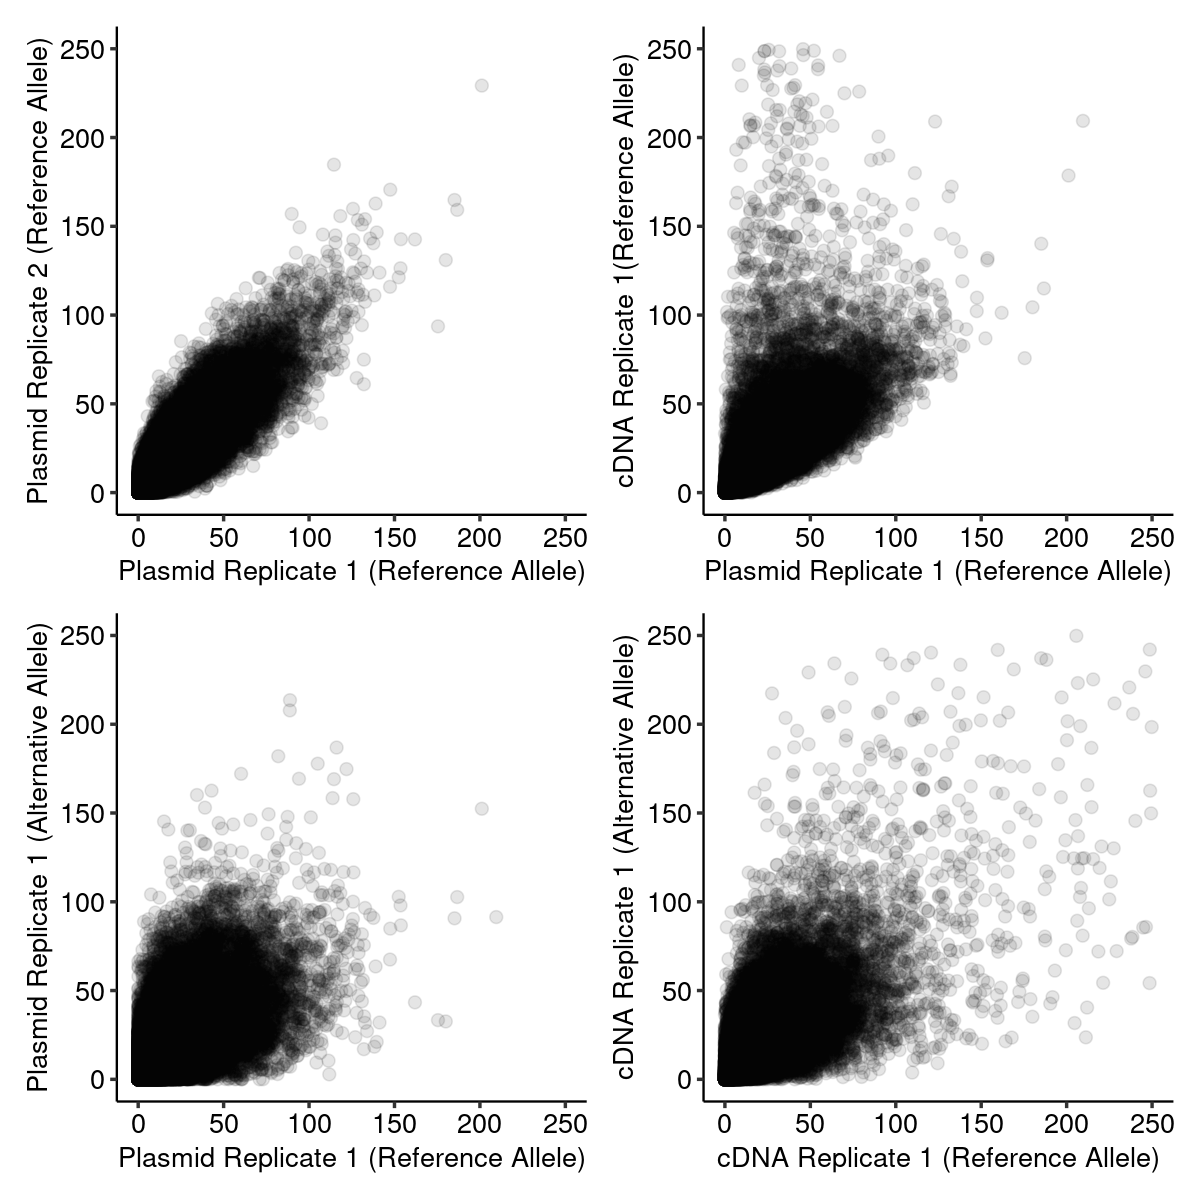

In [9]:
options(repr.plot.width = 10, repr.plot.height = 10)
(dna1vdna2 + dna1vrna1) / (dnaRefAlt + rnaRefAlt) & 
    theme_pubr(base_size = 16) & 
    xlim(c(0,250)) & 
    ylim(c(0,250))

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



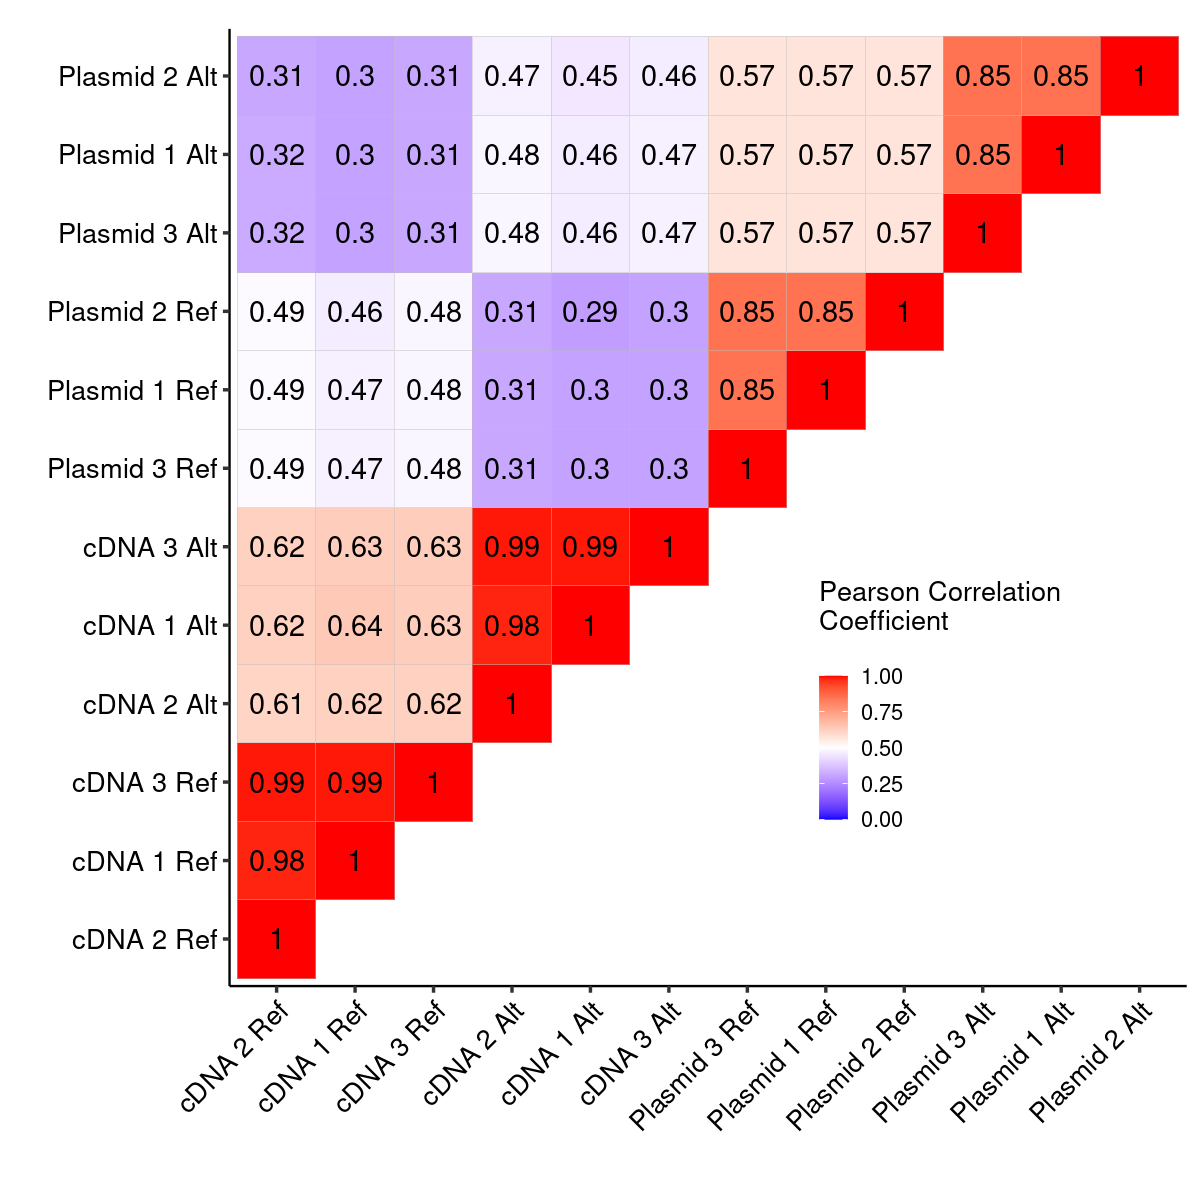

In [5]:
corMat = cor(mergedOligoCPM[,10:21], method = "pearson", use = "pairwise.complete.obs")
samples = c("Plasmid 1 Ref", "cDNA 1 Ref",
            "Plasmid 2 Ref", "cDNA 2 Ref",
            "Plasmid 3 Ref", "cDNA 3 Ref",
            "Plasmid 1 Alt", "cDNA 1 Alt",
            "Plasmid 2 Alt", "cDNA 2 Alt",
            "Plasmid 3 Alt", "cDNA 3 Alt")

colnames(corMat) = samples
rownames(corMat) = samples

options(repr.plot.width = 10, repr.plot.height = 10)
ggcorrplot(corMat,
           hc.order = T,
           tl.cex = 20,
           pch.cex = 20,
           lab_size = 6,
           lab = T,
           show.diag = T,
           type = "upper") + 
    theme_pubr(x.text.angle = 45, base_size = 16) +
    scale_fill_gradient2(limit = c(0,1), midpoint = 0.5,low = "blue",mid = "white", high =  "red", name = "Pearson Correlation   \nCoefficient\n") +
    theme(legend.position = c(0.75, 0.3)) +
    xlab("") + ylab("")

In [6]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblas-r0.3.3.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] vroom_1.3.2       ggpubr_0.4.0      ggcorrplot_0.1.3  patchwork_1.1.0  
 [5] data.table_1.13.2 forcats_0.5.0     stringr_1.4.0     dplyr_1.0.2      
 [9] purrr_0.3.4       readr_1.4.0       tidyr_1.1.2       tibble_3.0.4     
[13] ggplot2_3.3.2     tidyverse_1.3.0  

loaded via a namespace (and not attached):
 [1] httr_1.4.2    